# Numerical integration of Shallow Water Equations

In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
class ShallowWaterSolver:
    
    def __init__(self, gr, par):
                
        self.a = par["speeda"]        
        self.nx = gr["nx"]
        self.ng = gr["ng"]
        self.ilo = gr["ilo"]
        self.ihi = gr["ihi"]
        
        self.iIC = par["iIC"]
        self.islope = par["islope"]
        self.cfl = par["cfl"]
        
        self.dx = gr["dx"]
        self.dt = par["cfl"] * self.dx / abs(self.a)
        
        self.niter = int(par["tend"]/self.dt) + 1
        
        self.eta = np.zeros((self.niter, self.nx + 2*self.ng), dtype = np.float32)
        self.u = np.zeros((self.niter, self.nx + 2*self.ng), dtype = np.float32)
        
        self.c1 = np.zeros(self.nx + 2*self.ng, dtype = np.float32)
        self.c2 = np.zeros(self.nx + 2*self.ng, dtype = np.float32)
        self.x = gr["xmin"] + (np.arange(self.nx + 2*self.ng) - self.ng + 0.5) * self.dx
        
        self.H = 10
        
    def init_cond(self):
        """Definition of the initial conditions"""

        if self.iIC == 0: # Sinusoid
             self.eta[0, :] = 1. + 0.5 * np.sin(1./150*self.x)
        elif self.iIC == 1: # Square wave
            self.eta[0, :][self.x < 500] = 1.
            self.eta[0, :][self.x >= 500] = 0.1
        
        self.c1 = self.eta[0,:] - self.H/self.a * self.u[0,:]
        self.c2 = self.eta[0,:] + self.H/self.a * self.u[0,:]
            
    def bound_cond(self, it):
        """Definition of the boundary conditions"""

        # Trasmissive conditions on the right for u
        self.u[it, 0] = self.u[it-1, self.ilo+1]
        self.u[it, 1] = self.u[it-1, self.ilo]
        # Trasmissive conditions on the right for eta
        self.eta[it, 0] = self.eta[it-1, self.ilo+1]
        self.eta[it, 1] = self.eta[it-1, self.ilo]
        
        # Definition of c1 and c2 on the defined points
        self.c1[0] = self.eta[it, 0] - self.H*self.u[it, 0]/self.a
        self.c1[1] = self.eta[it, 1] - self.H*self.u[it, 1]/self.a
        self.c2[0] = self.eta[it, 0] + self.H*self.u[it, 0]/self.a
        self.c2[1] = self.eta[it, 1] + self.H*self.u[it, 1]/self.a

        # Reflective conditions on the left for u
        self.u[it, self.ihi+1] = -self.u[it-1, self.ihi]
        self.u[it, self.ihi+2] = -self.u[it-1, self.ihi-1]
        # Transmissive conditions on the right for eta
        self.eta[it, self.ihi+1] = self.eta[it-1, self.ihi]
        self.eta[it, self.ihi+2] = self.eta[it-1, self.ihi-1]
        
        # Definition of c1 and c2 on the defined points
        self.c1[self.ihi+1] = self.eta[it, self.ihi+1] - self.H*self.u[it, self.ihi+1]/self.a
        self.c1[self.ihi+2] = self.eta[it, self.ihi+2] - self.H*self.u[it, self.ihi+2]/self.a
        self.c2[self.ihi+1] = self.eta[it, self.ihi+1] + self.H*self.u[it, self.ihi+1]/self.a
        self.c2[self.ihi+2] = self.eta[it, self.ihi+2] + self.H*self.u[it, self.ihi+2]/self.a
                

    def minmod(self, a, b):
        """
        helper functions for the limiting
        """
        if abs(a) < abs(b) and a*b > 0.0:
            return a
        elif abs(b) < abs(a) and a*b > 0.0:
            return b
        else:
            return 0.0
    
    def maxmod(self, a, b):
        """
        helper functions for the limiting
        """
        if abs(a) > abs(b) and a*b > 0.0:
            return a
        elif abs(b) > abs(a) and a*b > 0.0:
            return b
        else:
            return 0.0    
                
    def update(self):

        """Slope definition, Riemann problem and flux definitions are merged in this 
        function."""
        
        # Since we know that the charateristic speed of c1 equation is -lambda (<0) and 
        # the charateristic speed of c2 equation is lambda (>0), the Riemann problem is
        # simplified and c1r and c2l are already defined.

        # Initialization of c1r and c2r
        c1r = np.zeros(self.nx + 2*self.ng, dtype = np.float32)
        c2l = np.zeros(self.nx + 2*self.ng, dtype = np.float32)

        # Initialization of the slopes for the two equations
        slope1 = np.zeros(self.nx+2*self.ng, dtype=np.float32)
        slope2 = np.zeros(self.nx+2*self.ng, dtype=np.float32)
        
        if self.islope == 0: # Godunov 1st order
            
            slope1[:] = 0.
            slope2[:] = 0.

        
        elif self.islope == 1: # Unlimited MUSCL
            omega = 0.

            for i in range(self.ilo-1, self.ihi+2):
                
                slope1[i] = ( 0.5*(1.+omega)*(self.c1[i]-self.c1[i-1]) + 0.5*(1.-omega)*(self.c1[i+1]-self.c1[i]) )/self.dx
                slope2[i] = ( 0.5*(1.+omega)*(self.c2[i]-self.c2[i-1]) + 0.5*(1.-omega)*(self.c2[i+1]-self.c2[i]) )/self.dx

        
        elif self.islope == 2: # MUSCL Superbee 2nd order
            
            for i in range(self.ilo - 1, self.ihi + 2):
                
                A = self.minmod( (self.c1[i+1] - self.c1[i]), 2.0*(self.c1[i] - self.c1[i-1]) )/self.dx
                B = self.minmod( (self.c1[i] - self.c1[i-1]), 2.0*(self.c1[i+1] - self.c1[i]) )/self.dx
                slope1[i] = self.maxmod(A, B)
                
                A = self.minmod( (self.c2[i+1] - self.c2[i]), 2.0*(self.c2[i] - self.c2[i-1]) )/self.dx
                B = self.minmod( (self.c2[i] - self.c2[i-1]), 2.0*(self.c2[i+1] - self.c2[i]) )/self.dx
                slope2[i] = self.maxmod(A, B)
        

        # Update of c1r and c2l according to the Riemann problem
        c1r[self.ilo:self.ihi+2] = self.c1[self.ilo:self.ihi+2] - 0.5*self.dx*(1.0 - self.a*self.dt/self.dx)*slope1[self.ilo:self.ihi+2]
        c2l[self.ilo:self.ihi+2] = self.c2[self.ilo-1:self.ihi+1] + 0.5*self.dx*(1.0 - self.a*self.dt/self.dx)*slope2[self.ilo-1:self.ihi+1]

        # Definition of the fluxes
        flux1 = - self.a * c1r
        flux2 = self.a * c2l

        # Definition of the update array 
        c1_new = np.zeros(self.nx + 2*self.ng, dtype = np.float32)
        c2_new = np.zeros(self.nx + 2*self.ng, dtype = np.float32)
        
        c1_new[self.ilo:self.ihi+1] = self.c1[self.ilo:self.ihi+1] + self.dt/self.dx*( flux1[self.ilo:self.ihi+1] - flux1[self.ilo+1:self.ihi+2] )
        c2_new[self.ilo:self.ihi+1] = self.c2[self.ilo:self.ihi+1] + self.dt/self.dx*( flux2[self.ilo:self.ihi+1] - flux2[self.ilo+1:self.ihi+2] )
                
        return c1_new, c2_new
    
    def solver(self):
        """Functions wrapper and equation solver"""
        self.init_cond()
        
        for i in range(1, self.niter):
            
            self.bound_cond(i)
            
            c1, c2 = self.update() 
            
            self.eta[i,:] = (c1 + c2)/2
            self.u[i,:] = (self.a/self.H)*(c2 - c1)/2
            
            self.c1 = np.copy(c1)
            self.c2 = np.copy(c2)

In [12]:
#--------------------------------------------------

gr = {} # GRID DEFINITION PARAMETERS
gr["xmin"] = 0.  # Left Boundary
gr["xmax"] = 1000.   # Right Boundary
gr["nx"] = 200   # Number of cells
gr["ng"] = 2      # Number of ghostcell
gr["dx"] = (gr["xmax"]-gr["xmin"])/gr["nx"]  # mesh size
gr["ilo"] = gr["ng"]            # indexes low and high used for the BC location
gr["ihi"] = gr["ng"]+gr["nx"] -1 # (remember python is zero-based!)

#--------------------------------------------------

par = {}
par["cfl"] = 0.8        # Courant number coefficient
par["tend"] = 200.       # Output time
par["nitermax"] = 500   # Maximum number of time steps
par["nfreq"] = 5        # Output frequency to screen
par["dt"] = 0.1
par["iIC"] = 1       # Choice of inital Profile (1=Sinusoid, 2=Square)    
par["islope"] = 0       
par["speeda"] = np.sqrt(9.8*10)

## Initial conditions plotter

In [13]:
## PLOT CONDIZIONI INIZIALI ##
par["islope"] = 0

par["iIC"] = 0 # Sinusoide
sol = ShallowWaterSolver(gr, par)
sol.solver()

eta1 = sol.eta[0,sol.ilo:sol.ihi+1]
u1 = sol.u[0,sol.ilo:sol.ihi+1]

par["iIC"] = 1 # Step
sol = ShallowWaterSolver(gr, par)
sol.solver()

eta2 = sol.eta[0,sol.ilo:sol.ihi+1]
u2 = sol.u[0,sol.ilo:sol.ihi+1]

x = sol.x[sol.ilo:sol.ihi+1]

In [14]:
sol.dt

0.40406101782088427

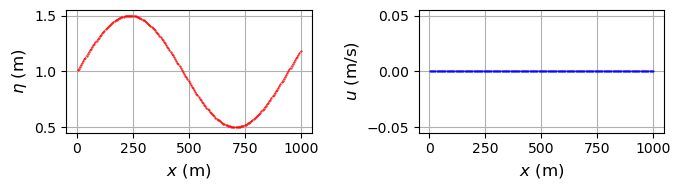

In [65]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = [7,2])

for (var, ax, title) in zip([eta1, u1], axs, ["$\eta$ (m)", "$u$ (m/s)"]):
    if ax == axs[0]:
        col = "red"
    else:
        col = "blue"
    ax.plot(x, var, color = col, marker = "o", markersize = .5, linewidth = .3)
    ax.set_xlabel("$x$ (m)", fontsize = 12)
    ax.set_ylabel(title, fontsize = 12)
    ax.grid()
    
#fig.suptitle("Condizioni iniziali $\eta_1(x,0)$, $u_1(x,0)$")
fig.tight_layout()

plt.savefig("./immagini/IC1.pdf", bbox_inches = "tight")

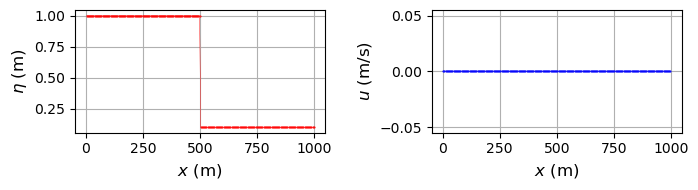

In [66]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = [7,2])

for (var, ax, title) in zip([eta2, u2], axs, ["$\eta$ (m)", "$u$ (m/s)"]):
    if ax == axs[0]:
        col = "red"
    else:
        col = "blue"
    ax.plot(x, var, marker = "o", markersize = .5, color = col, linewidth = .3)
    ax.set_xlabel("$x$ (m)", fontsize = 12)
    ax.set_ylabel(title, fontsize = 12)
    ax.grid()
    
#fig.suptitle("Condizioni iniziali $\eta_2(x,0)$, $u_2(x,0)$")
fig.tight_layout()

plt.savefig("./immagini/IC2.pdf", bbox_inches = "tight")

## System evolution

In [47]:
def plot_evo(ic, cfl = 0.8):
    par["iIC"] = ic
    par["islope"] = 0
    par["cfl"] = cfl
    
    sol = ShallowWaterSolver(gr, par)
    sol.solver()
    
    eta = sol.eta[:,sol.ilo:sol.ihi+1]
    u = sol.u[:,sol.ilo:sol.ihi+1]
    x = sol.x[sol.ilo:sol.ihi+1]
    
    nsnap = 5
    di = int(len(eta)/nsnap)
    
    fig, axs = plt.subplots(nrows = 2, ncols = nsnap, figsize = [15,5])
    axs = axs.ravel()
        
    if ic == 0:
        eta_ylim = [0.4, 1.6]
        u_ylim = [-0.5, 0.5]
        
    elif ic == 1:
        eta_ylim = [0,1.1]
        u_ylim = [-0.5, 0.5]
    
    for i in range(nsnap):
            axs[i].plot(x, eta[i*di,:], linewidth = .3, marker = "o", markersize = .5, color = "red")
            axs[i].set_title("$t$ = %2.2f"%(sol.dt*i*di), fontsize = 25)
            axs[i].set_ylim(eta_ylim)
            axs[i].grid()
            if i == 0:
                axs[i].set_ylabel("$\eta$ (m)", fontsize = 20)
    for i in range(nsnap,nsnap*2):
            axs[i].plot(x, u[(i-nsnap)*di,:], linewidth = .3, marker = "o", markersize = .5, color = "blue")
            axs[i].set_ylim(u_ylim)
            axs[i].grid()
            if i-nsnap == 0:
                axs[i].set_ylabel("$u$ (m/s)", fontsize = 20)
            if i-nsnap == 2:
                axs[i].set_xlabel("$x$ (m)", fontsize = 20)
    
    fig.tight_layout()
    if cfl != 0.8:
        fig.savefig("./immagini/Evo%1d_UNSTABLE.pdf"%(ic), bbox_inches = "tight")
    else:
        plt.savefig("./immagini/Evo%1d.pdf"%(ic), bbox_inches = "tight")


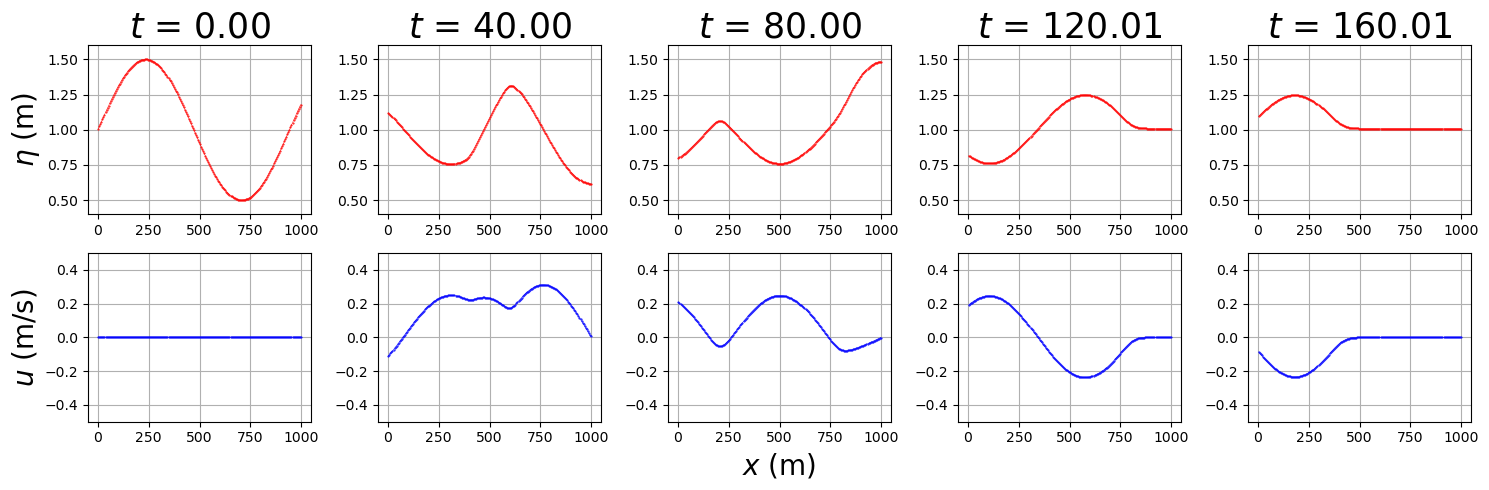

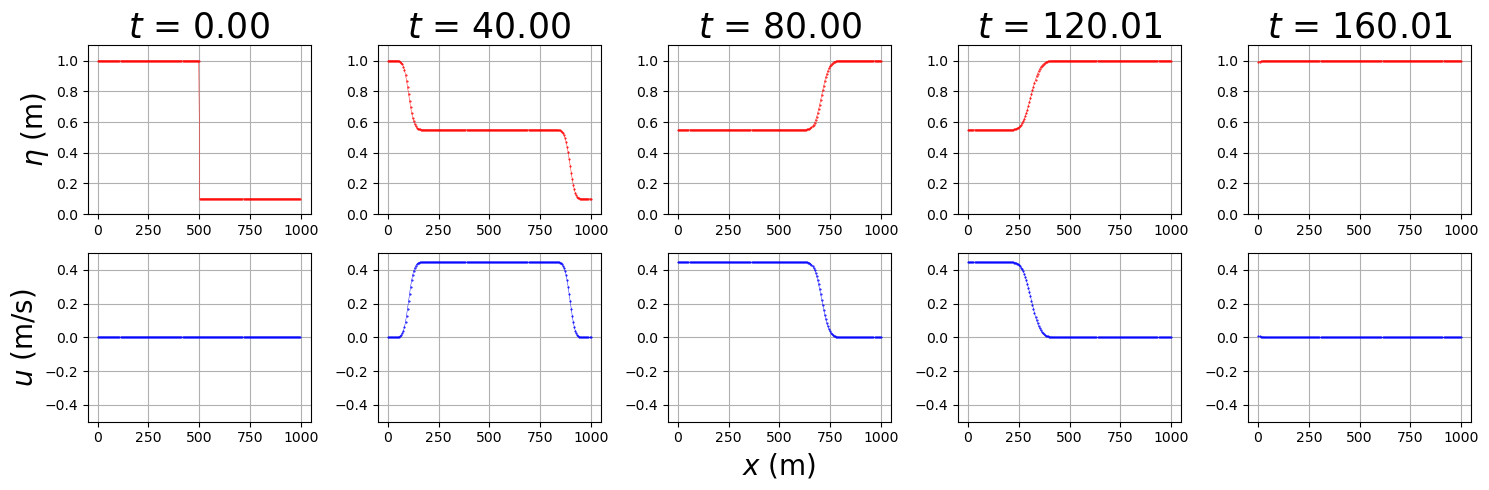

In [48]:
plot_evo(0)
plot_evo(1)

## Plot of the three solutions

In [52]:
def plotter(i, ic, cfl = 0.8):
    
    fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = [7,5])
    
    col_list = ["red", "blue", "green"]
    label_list = ["Metodo di Godunov (slope = 0)",
                 "Metodo MH (slope non limitata)",
                 "Metodo MH (limitazione SUPERBEE)"]
    
    par["iIC"] = ic
    par["cfl"] = cfl
    
    for (islope, color, label) in zip(range(3), col_list, label_list):
        par["islope"] = islope
        sol = ShallowWaterSolver(gr, par)
        sol.solver()
        
        eta = sol.eta[i,sol.ilo:sol.ihi+1]
        u = sol.u[i,sol.ilo:sol.ihi+1]
        x = sol.x[sol.ilo:sol.ihi+1]
        
        #-------------------------------------------
        
        axs[0].plot(x, eta, linewidth = .5, marker = "o", markersize = .5, color = color,
                   label = label)
        axs[0].grid()
        axs[0].legend(prop={'size': 9})
        axs[0].set_ylabel("$\eta$ (m)", fontsize = 15)
        axs[0].set_xlabel("$x$ (m)", fontsize = 15)
        #-------------------------------------------
        
        axs[1].plot(x, u, linewidth = .5, marker = "o", markersize = .5, color = color,
                   label = label)
        axs[1].grid()
        #axs[1].legend()
        axs[1].set_ylabel("$u$ (m/s)", fontsize = 15)
        axs[1].set_xlabel("$x$ (m)", fontsize = 15)
        
    #fig.suptitle("Soluzione Shallow Water 1D [t = %2.2f]"%(i*sol.dt), fontsize = 15)
    fig.suptitle("t = %2.2f"%(i*sol.dt), fontsize = 20)

    fig.tight_layout()
    if cfl != 0.8:
        axs[0].legend(prop={'size': 8})
        fig.savefig("./immagini/SW%1d_%2.2f_UNSTABLE.pdf"%(ic, i*sol.dt))
    else:
        fig.savefig("./immagini/SW%1d_%2.2f.pdf"%(ic, i*sol.dt))

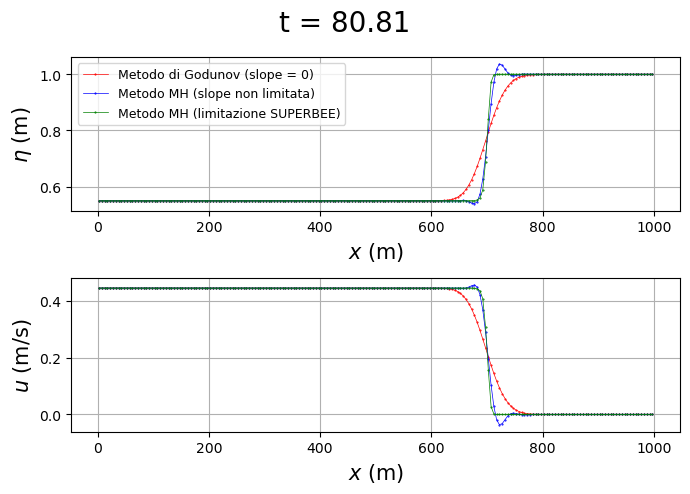

In [53]:
plotter(200, 1)

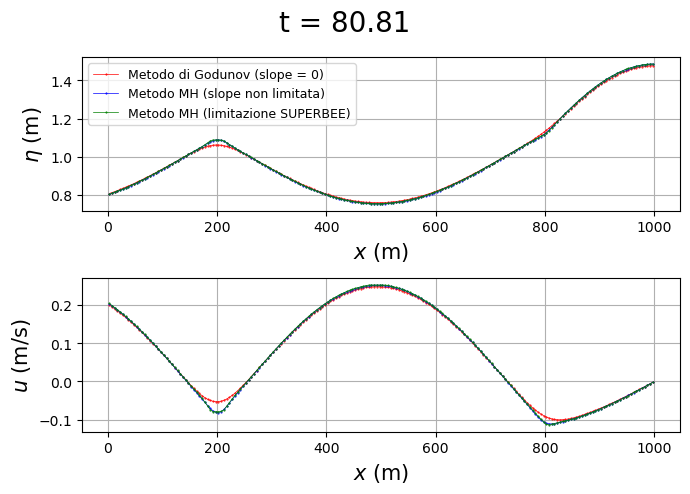

In [54]:
plotter(200, 0)
#plotter(150, 0)

##  Comparison between MH unlimited and with SUPERBEE limitation

In [55]:
def plot_differences(i, ic):
    
    par["cfl"] = 0.8
    fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = [7,5])
    
    par["iIC"] = ic
    
    par["islope"] = 1
    sol = ShallowWaterSolver(gr, par)
    sol.solver()
    eta_m = sol.eta[i, sol.ilo:sol.ihi+1]
    u_m = sol.u[i, sol.ilo:sol.ihi + 1]
    
    par["islope"] = 2
    sol = ShallowWaterSolver(gr, par)
    sol.solver()
    eta_s = sol.eta[i, sol.ilo:sol.ihi+1]
    u_s = sol.u[i, sol.ilo:sol.ihi + 1]
    x = sol.x[sol.ilo:sol.ihi+1]
    #----------------------------------------
    axs[0].plot(x, eta_m - eta_s, linewidth = .5, marker = "o", markersize = 1, color = "red")
    axs[0].set_ylabel("$\eta_{UN}$ - $\eta_{SB}$ (m)", fontsize = 15)
    axs[0].set_xlabel("$x$ (m)", fontsize = 15)
    axs[0].grid()
    #axs[0].set_ylim([-0.05, 0.05])
    
    #---------------------------------------
    axs[1].plot(x, u_m - u_s, linewidth = .5, marker = "o", markersize = 1, color = "blue")
    axs[1].set_ylabel("$u_{UN}$ - $u_{SB}$ (m/s)", fontsize = 15)
    axs[1].set_xlabel("$x$ (m)", fontsize = 15)
    axs[1].grid()
    #axs[1].set_ylim([-0.05, 0.05])
    
    fig.suptitle("$t$ = %2.2f"%(i*sol.dt), fontsize = 20)
    fig.tight_layout()
    
    plt.savefig("./immagini/Diff%1d_%2.2f.pdf"%(ic, i*sol.dt), bbox_inches = "tight")

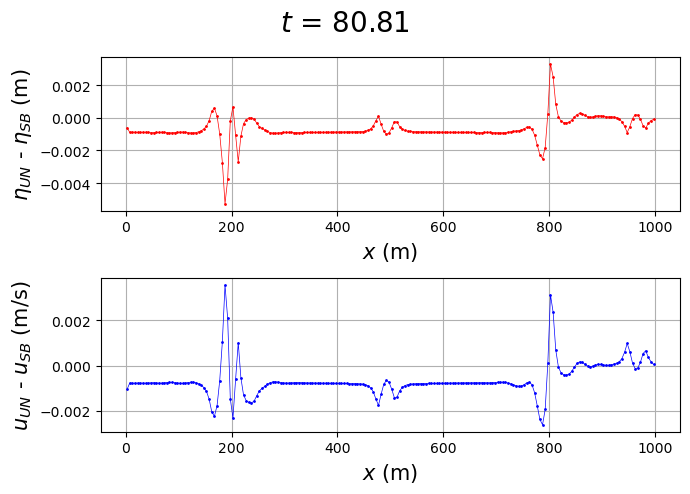

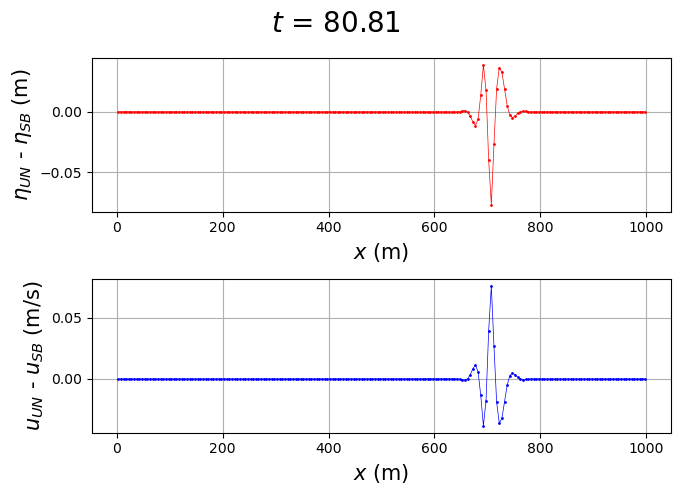

In [56]:
plot_differences(200,0)

plot_differences(200,1)

## Effect of CFL > 1 on the solution

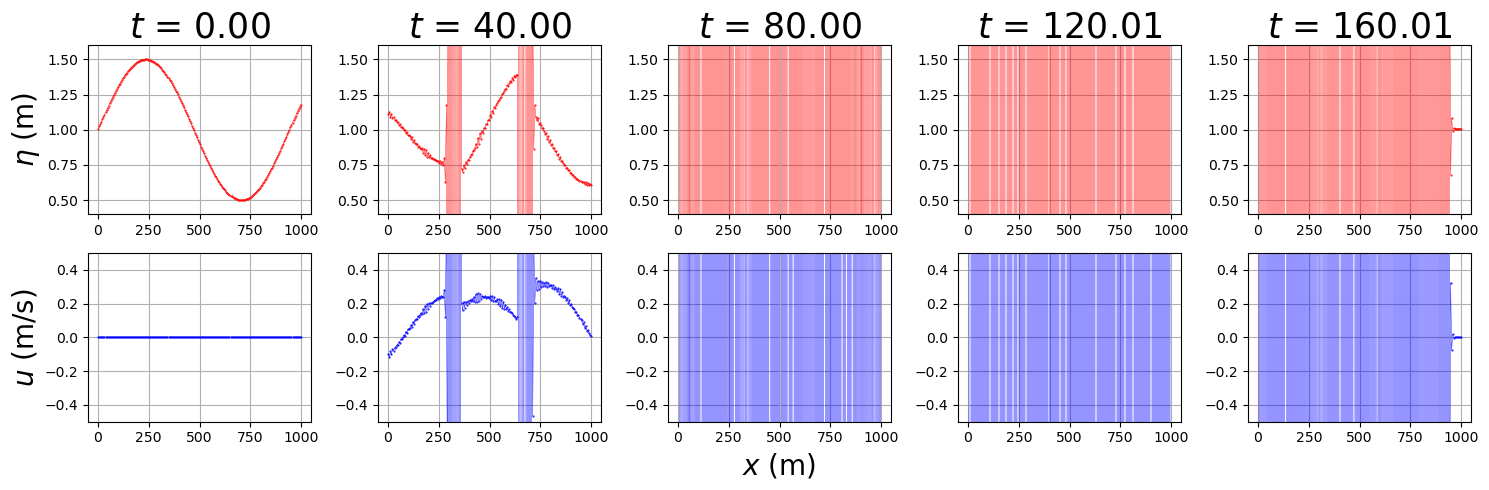

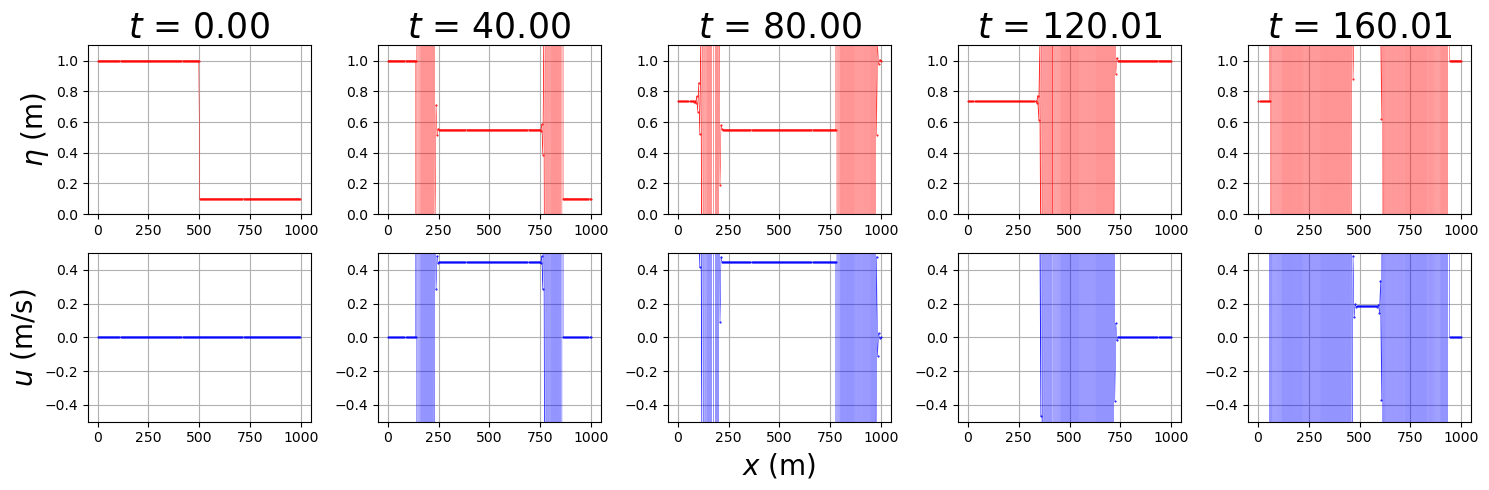

In [57]:
plot_evo(0, 1.1)
plot_evo(1, 1.1)

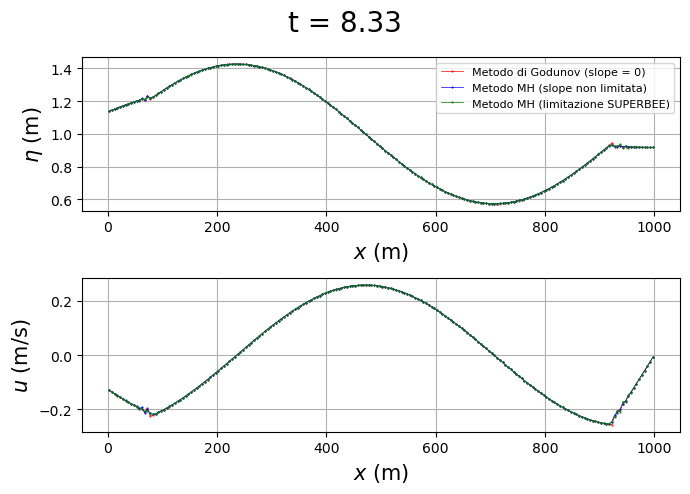

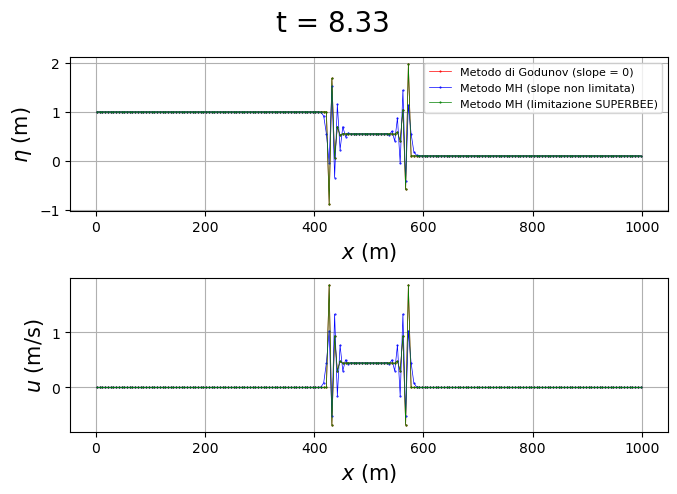

In [58]:
plotter(15, 0, cfl = 1.1)
plotter(15, 1, cfl = 1.1)